<a href="https://colab.research.google.com/github/ShubhamP1028/DeepLearning/blob/main/Regularisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b>Regularisation</b>

---
Think of training a neural network like training a parrot 🦜 to say useful things.

↪ Without rules, the parrot might memorize exactly what you said in the training sessions (“Hello, Newbie!”) but freeze when you say something slightly different (“Hi, Newbie!”) ⤵

↪ Regularization is like disciplining the parrot so it understands the idea behind what you taught, instead of copying your words.

In ML terms ➡ Regularization = extra rules or penalties during training that force the model to keep its weights and predictions simpler and more general, so it performs well on unseen data.

---


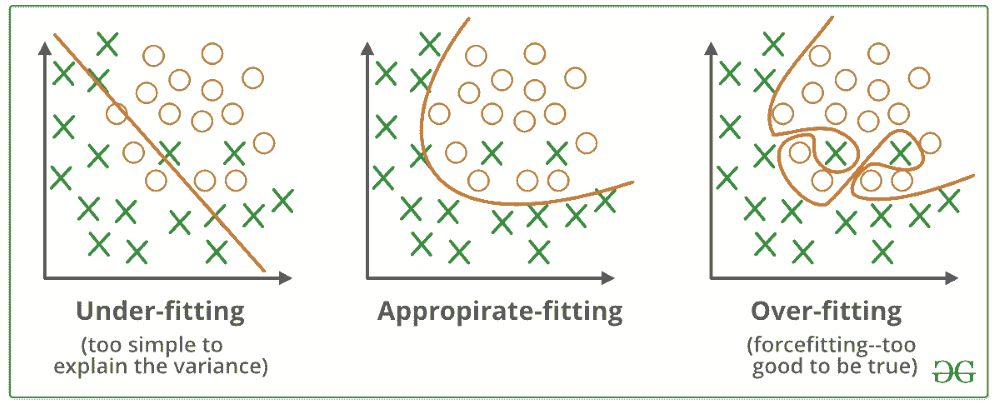

---
<b>L1 & L2 Regularization (Weight Penalties)</b>

Add a penalty to the loss if the model’s weights get too big.

*  L2 (weight decay): penalizes large weights by squaring them. Makes weights smaller but keeps all of them.
Formula: $$\text{Loss}_{\text{new}} = \text{Loss}_{\text{old}} + \lambda \sum w^2$$

*  L1: penalizes absolute values of weights. Pushes many weights to exactly zero → sparsity.

Formula: $$\text{Loss}_{\text{new}} = \text{Loss}_{\text{old}} + \lambda \sum |w|$$


Effect: Prevents any single neuron from becoming a “know-it-all.”

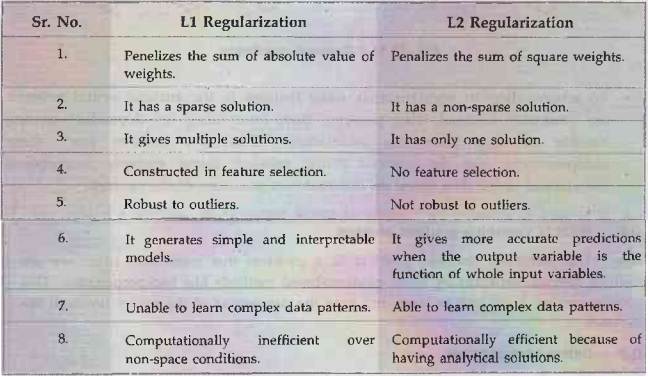

---
<b>Dropout</b>
*  Randomly “turns off” some neurons during training.
*  Forces the network to learn multiple redundant ways to make predictions instead of relying on one path.

Example: If a student knows they might not be allowed to use their favorite formula sheet in the test, they study the concepts instead.

At inference, all neurons are active, but their outputs are scaled.

---
we'll Train three models:

- Model A: L1 Regularization

- Model B: L2 Regularization

- Model C: Dropout

Compare their training/validation loss curves.

---

PyTorch Version - regularisation methods with gradient track plots

X_train: (2008, 8), y_train: (2008,)
X_val: (503, 8), y_val: (503,)
Epoch 10, Loss: 0.5715, Val Loss: 0.3154
Epoch 20, Loss: 0.4534, Val Loss: 0.2398
Epoch 30, Loss: 0.4154, Val Loss: 0.2290
Epoch 40, Loss: 0.3764, Val Loss: 0.1921
Epoch 50, Loss: 0.3513, Val Loss: 0.1731
Epoch 10, Loss: 0.3664, Val Loss: 0.4368
Epoch 20, Loss: 0.2542, Val Loss: 0.2817
Epoch 30, Loss: 0.2055, Val Loss: 0.2038
Epoch 40, Loss: 0.1776, Val Loss: 0.1790
Epoch 50, Loss: 0.1657, Val Loss: 0.1674
Epoch 10, Loss: 0.2706, Val Loss: 0.2666
Epoch 20, Loss: 0.2377, Val Loss: 0.2312
Epoch 30, Loss: 0.2028, Val Loss: 0.2046
Epoch 40, Loss: 0.1845, Val Loss: 0.1803
Epoch 50, Loss: 0.1677, Val Loss: 0.1767


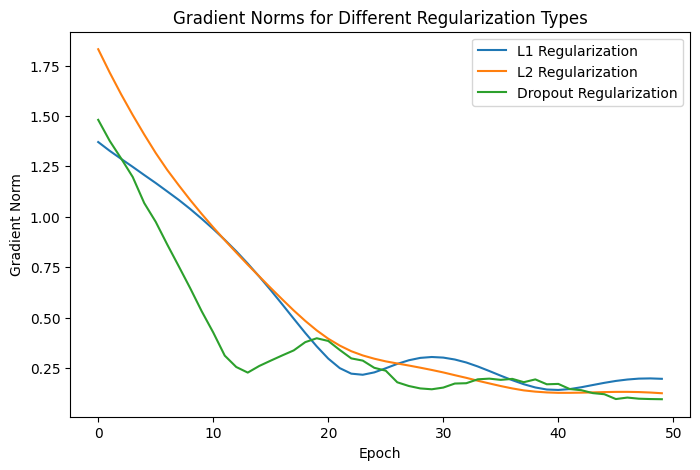

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# 1. Load dataset
df = pd.read_csv("goldstock.csv")

# 2. Parse dates if necessary
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])

# 3. Feature engineering
df['open_close'] = df['Open'] - df['Close']
df['low_high'] = df['Low'] - df['High']
df['is_quarter_end'] = df['Date'].dt.month % 3 == 0

# Target: whether next day's Close is higher than today's Close (classification)
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# 4. Drop last row with NaN target
df = df.dropna(subset=['Target'])

# 5. Features and labels
features = ['Open', 'High', 'Low', 'Close', 'Volume',
            'open_close', 'low_high', 'is_quarter_end']
X = df[features]
y = df['Target']

# 6. Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 7. Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, shuffle=False
)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_val = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

# 7. Model architecture
class StockModel(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.0):
        super(StockModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# 8. Training function
def train_model(reg_type="l2", lambda_reg=0.001, dropout=0.0):
    model = StockModel(len(features), dropout)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=(lambda_reg if reg_type=="l2" else 0.0))
    criterion = nn.MSELoss()

    grad_norms = []
    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        # L1 regularization
        if reg_type == "l1":
            l1_norm = sum(torch.sum(torch.abs(p)) for p in model.parameters())
            loss += lambda_reg * l1_norm

        loss.backward()

        # Track gradient norms
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        grad_norms.append(total_norm ** 0.5)

        optimizer.step()

        if (epoch+1) % 10 == 0:
            val_loss = criterion(model(X_val), y_val).item()
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

    return grad_norms

# 9. Run for each type
grad_l1 = train_model("l1", lambda_reg=0.001)
grad_l2 = train_model("l2", lambda_reg=0.001)
grad_dropout = train_model("l2", lambda_reg=0.0, dropout=0.3)  # Dropout doesn't use L1/L2

# 10. Plot gradient norms
plt.figure(figsize=(8,5))
plt.plot(grad_l1, label="L1 Regularization")
plt.plot(grad_l2, label="L2 Regularization")
plt.plot(grad_dropout, label="Dropout Regularization")
plt.xlabel("Epoch")
plt.ylabel("Gradient Norm")
plt.legend()
plt.title("Gradient Norms for Different Regularization Types")
plt.show()



Tensorflow version:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


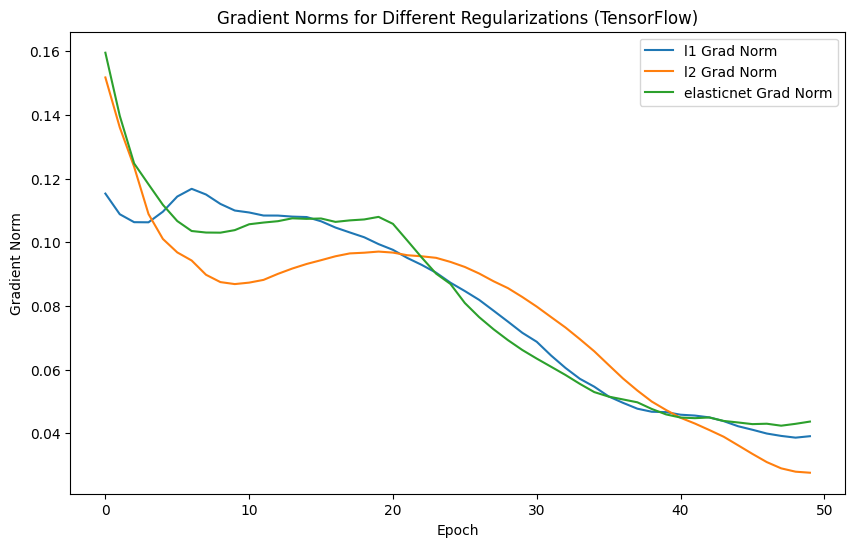

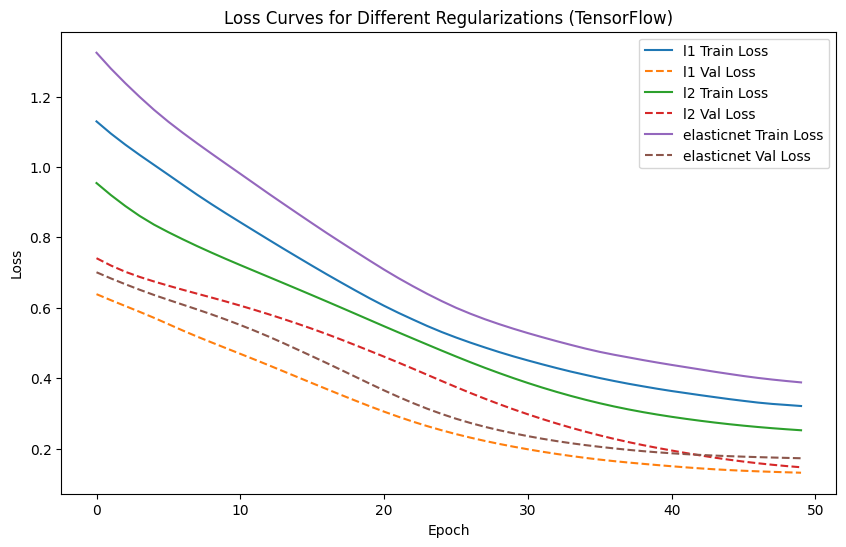

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# ==========================
# 1. Load and preprocess data
# ==========================
df = pd.read_csv("goldstock.csv")

# Handle missing values
df = df.dropna()

# Feature engineering
df['open-close'] = df['Open'] - df['Close']
df['low-high'] = df['Low'] - df['High']
df['is_quarter_end'] = np.where(df['Date'].str.endswith(('03', '06', '09', '12')), 1, 0)

# Target: 1 if Close > Open else 0
df['Target'] = np.where(df['Close'] > df['Open'], 1, 0)

# Features & target
X = df[['open-close', 'low-high', 'is_quarter_end']].values
y = df['Target'].values

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# ==========================
# 2. Training function
# ==========================
def train_with_regularization(reg_type, reg_strength, epochs=50):
    tf.keras.backend.clear_session()

    if reg_type == "l1":
        regularizer = tf.keras.regularizers.l1(reg_strength)
    elif reg_type == "l2":
        regularizer = tf.keras.regularizers.l2(reg_strength)
    elif reg_type == "elasticnet":
        regularizer = tf.keras.regularizers.l1_l2(l1=reg_strength, l2=reg_strength)
    else:
        regularizer = None

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizer, input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=regularizer),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    loss_fn = tf.keras.losses.BinaryCrossentropy()

    train_loss_results = []
    val_loss_results = []
    grad_norms = []

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            y_pred = model(X_train, training=True)
            loss = loss_fn(y_train, y_pred)
            if regularizer:
                loss += sum(model.losses)  # Add regularization losses

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        grad_norm = np.mean([tf.norm(g).numpy() for g in grads if g is not None])
        grad_norms.append(grad_norm)

        # Validation loss
        val_pred = model(X_val, training=False)
        val_loss = loss_fn(y_val, val_pred)

        train_loss_results.append(loss.numpy())
        val_loss_results.append(val_loss.numpy())

    return model, train_loss_results, val_loss_results, grad_norms

# ==========================
# 3. Train models with L1, L2, and ElasticNet
# ==========================
results = {}
for reg in ["l1", "l2", "elasticnet"]:
    model, train_losses, val_losses, grad_norms = train_with_regularization(reg, reg_strength=0.01)
    results[reg] = {"train": train_losses, "val": val_losses, "grad": grad_norms}

# ==========================
# 4. Plot gradient norms
# ==========================
plt.figure(figsize=(10, 6))
for reg in results:
    plt.plot(results[reg]['grad'], label=f"{reg} Grad Norm")
plt.title("Gradient Norms for Different Regularizations (TensorFlow)")
plt.xlabel("Epoch")
plt.ylabel("Gradient Norm")
plt.legend()
plt.show()

# ==========================
# 5. Plot loss curves
# ==========================
plt.figure(figsize=(10, 6))
for reg in results:
    plt.plot(results[reg]['train'], label=f"{reg} Train Loss")
    plt.plot(results[reg]['val'], '--', label=f"{reg} Val Loss")
plt.title("Loss Curves for Different Regularizations (TensorFlow)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
